## Part I (Work in progress)

In [3]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.device_count())

print('GPU disponible :', torch.cuda.is_available())
print('Nom du GPU :', torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'Aucun GPU détecté')

True
12.1
1
GPU disponible : True
Nom du GPU : NVIDIA GeForce RTX 4070 Laptop GPU


In [4]:
# Imports and Configuration

import os
import numpy as np
import pickle
import scipy.sparse as sp
import torch
import dgl

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Parameters (here we are working with the Epinions dataset)
DATASET_PATH = './datasets/epinions/dataset.pkl'
SAVE_PATH = './datasets/epinions/'

# Create directories if not exist
os.makedirs(SAVE_PATH, exist_ok=True)

# Parameters
NUM_USERS = 0
NUM_ITEMS = 0
SEED = 42

# Fix Random Seed for Reproducibility 
def fix_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_random_seed(SEED)

print("Done.")


Using device: cuda
Done.


In [5]:
# Data loading

import os
import pickle

DATASET_PATH = './datasets/epinions/dataset.pkl'

def load_data(path):
    """ Load the dataset from a .pkl file """
    try:
        with open(path, 'rb') as file:
            data = pickle.load(file)
        print(f"Data successfully loaded from {path}")
        return data
    except FileNotFoundError:
        print(f"Error: {path} not found.")
        return None

# Load dataset
dataset = load_data(DATASET_PATH)

if dataset:
    train_matrix = dataset['train']
    trust_matrix = dataset['trust']
    
    # assigning number of users and items
    NUM_USERS = dataset['userCount']
    NUM_ITEMS = dataset['itemCount']

    print(f"Loaded dataset: {NUM_USERS} users, {NUM_ITEMS} items")
    print(f"Train matrix shape: {train_matrix.shape}")
    print(f"Trust matrix shape: {trust_matrix.shape}")
else:
    print("Dataset not loaded. Check the path.")


Data successfully loaded from ./datasets/epinions/dataset.pkl
Loaded dataset: 14680 users, 233261 items
Train matrix shape: (14680, 233261)
Trust matrix shape: (14680, 14680)


C:\Users\medta\AppData\Local\Temp\ipykernel_31816\578672017.py:12: DeprecationWarning: Please import `coo_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.coo` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)
C:\Users\medta\AppData\Local\Temp\ipykernel_31816\578672017.py:12: DeprecationWarning: Please import `csr_matrix` from the `scipy.sparse` namespace; the `scipy.sparse.csr` namespace is deprecated and will be removed in SciPy 2.0.0.
  data = pickle.load(file)


In [6]:
# Data preprocessing

def binarize_matrix(matrix):
    """ Convert matrix values to binary (0/1) """
    return (matrix != 0).astype(float)

# Convert matrices to binary format
if dataset:
    binary_train_matrix = binarize_matrix(train_matrix)
    print(f"Number of interactions in User-Item Matrix: {binary_train_matrix.nnz}")
    print(f"Number of interactions in Trust Matrix: {trust_matrix.nnz}")
else:
    print("Dataset not loaded. Cannot proceed with preprocessing.")


Number of interactions in User-Item Matrix: 447312
Number of interactions in Trust Matrix: 632144


In [7]:
import dgl
import torch

print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch.cuda.current_device())
print(torch.cuda.get_device_name(torch.cuda.current_device()))

# To check DGL tensor device
g = dgl.graph(([0, 1], [1, 2]))
g = g.to('cuda' if torch.cuda.is_available() else 'cpu')
print('DGL graph device:', g.device)

12.1
True
0
NVIDIA GeForce RTX 4070 Laptop GPU
DGL graph device: cuda:0


In [8]:
import dgl
import torch
print(dgl.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
# La ligne suivante provoquait une erreur car DGL n'a plus d'attribut 'backend'.
# Pour vérifier le backend, utilisez torch (PyTorch est le backend par défaut de DGL).

2.0.0+cu121
12.1
True


In [9]:
# Graph Construction

def create_user_item_graph(train_matrix, num_users, num_items):
    """ Create a bipartite User-Item graph """
    a = sp.csr_matrix((num_users, num_users))  # Create an empty sparse matrix for user-user connections
    b = sp.csr_matrix((num_items, num_items)) # Create an empty sparse matrix for item-item connections
    print("train_matrix shape:", train_matrix.shape)
    print("num_users:", num_users)
    print("num_items:", num_items)

    print("a shape:", a.shape)
    print("b shape:", b.shape)

    # Construct the bipartite matrix
    mat = sp.vstack([sp.hstack([a, train_matrix]), sp.hstack([train_matrix.transpose(), b])])
    mat = (mat != 0).astype(float).tocoo()

    # Create DGL graph
    ui_graph = dgl.graph((mat.row, mat.col), num_nodes=mat.shape[0])
    ui_graph = ui_graph.to(device)  # Move graph to device (GPU/CPU)
    return ui_graph

def create_user_user_graph(trust_matrix):
    """ Create a User-User graph """
    g = dgl.from_scipy(trust_matrix)
    g = g.to(device)  # Move graph to device (GPU/CPU)
    return g

# Create the graphs
if dataset:
    
    ui_graph = create_user_item_graph(train_matrix, NUM_USERS, NUM_ITEMS)
    uu_graph = create_user_user_graph(trust_matrix)

    print(f"User-Item Graph - Nodes: {ui_graph.num_nodes()}, Edges: {ui_graph.num_edges()}")
    print(f"User-User Graph - Nodes: {uu_graph.num_nodes()}, Edges: {uu_graph.num_edges()}")
else:
    print("Dataset not loaded. Cannot construct graphs.")

print("trust_matrix shape:", trust_matrix.shape)
print("Nb de liens (non zeros):", trust_matrix.nnz)
print("Densité:", trust_matrix.nnz / (trust_matrix.shape[0]**2))


train_matrix shape: (14680, 233261)
num_users: 14680
num_items: 233261
a shape: (14680, 14680)
b shape: (233261, 233261)
User-Item Graph - Nodes: 247941, Edges: 894624
User-User Graph - Nodes: 14680, Edges: 632144
trust_matrix shape: (14680, 14680)
Nb de liens (non zeros): 632144
Densité: 0.0029333501622255715


Displaying User-Item Interactions


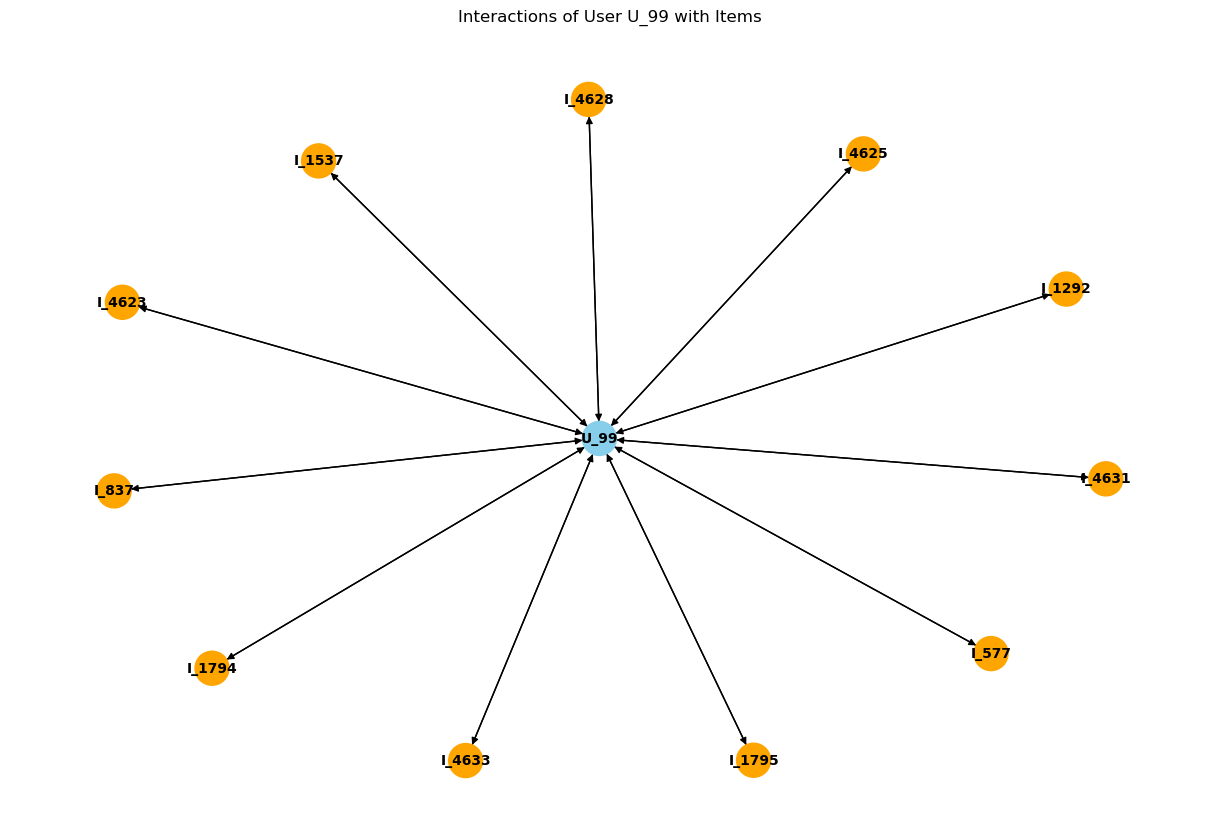

Relations of User U_99 with Items:
U_99 -> I_4633: 1
U_99 -> I_4631: 1
U_99 -> I_4628: 1
U_99 -> I_4625: 1
U_99 -> I_4623: 1
U_99 -> I_1795: 1
U_99 -> I_1794: 1
U_99 -> I_1537: 1
U_99 -> I_1292: 1
U_99 -> I_837: 1
U_99 -> I_577: 1
Displaying User-User Connections


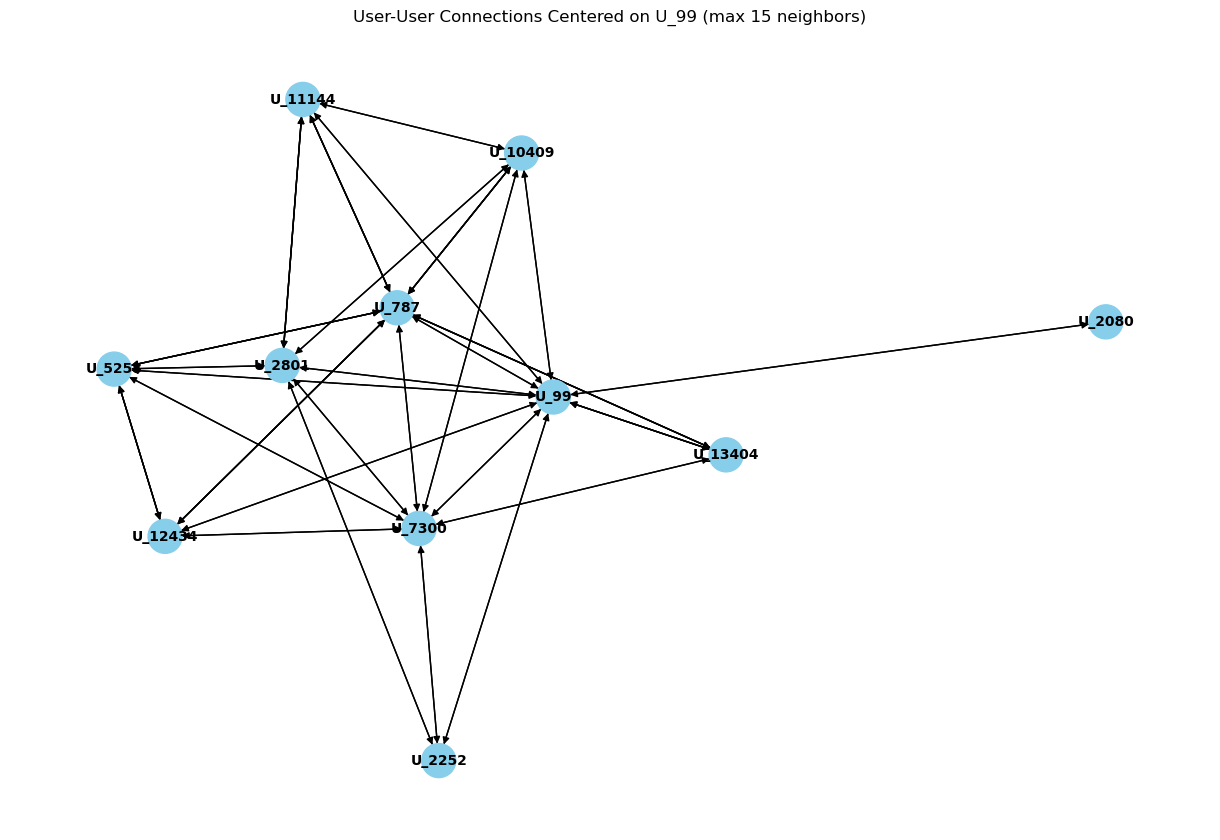

In [10]:
import matplotlib.pyplot as plt
import networkx as nx
import dgl

def visualize_user_item_graph(graph, num_users, num_items, user_id=0):
    """
    Visualize the interactions of a specific user with their items.
    Users are represented in blue and items in orange.
    """
    # Convert the DGL graph to a NetworkX graph for visualization
    nx_graph = graph.cpu().to_networkx()

    # Retrieve the neighbors (items) of the user
    neighbors = list(nx_graph.neighbors(user_id))
    
    # Create a subgraph centered on the user
    subgraph = nx_graph.subgraph([user_id] + neighbors)

    # Create labels for nodes: 'U_' prefix for users, 'I_' prefix for items
    labels = {user_id: f"U_{user_id}"}
    for node in neighbors:
        item_index = node - num_users
        labels[node] = f"I_{item_index}"

    # Node colors: blue for user, orange for items
    colors = ['skyblue' if node == user_id else 'orange' for node in subgraph.nodes]

    # Radial layout for highlighting connections
    pos = nx.spring_layout(subgraph, seed=42, center=(0.5, 0.5), scale=1.0)

    # Plotting
    plt.figure(figsize=(12, 8))
    nx.draw(subgraph, pos, labels=labels, node_size=600, node_color=colors, font_size=10, font_weight='bold')
    plt.title(f"Interactions of User U_{user_id} with Items")
    plt.show()


def visualize_user_user_graph(graph, num_users, user_id=0, max_neighbors=15):
    """
    Visualize the User-User connections centered around a specific user.
    All nodes (users) are represented in blue.
    - max_neighbors: Limits the number of neighbors to display.
    """
    # Convert the DGL graph to a NetworkX graph for visualization
    nx_graph = graph.cpu().to_networkx()

    # Retrieve the neighbors (other users) of the user
    neighbors = list(nx_graph.neighbors(user_id))
    
    # Limit the number of neighbors to display
    if max_neighbors and len(neighbors) > max_neighbors:
        neighbors = neighbors[:max_neighbors]
    
    # Create a subgraph centered on the user
    subgraph = nx_graph.subgraph([user_id] + neighbors)

    # Create labels for nodes with 'U_' prefix for users
    labels = {node: f"U_{node}" for node in subgraph.nodes}

    # Node colors: blue for all nodes
    colors = ['skyblue' for _ in subgraph.nodes]

    # Radial layout for highlighting connections
    pos = nx.spring_layout(subgraph, seed=42, center=(0.5, 0.5), scale=1.0)

    # Plotting
    plt.figure(figsize=(12, 8))
    nx.draw(subgraph, pos, labels=labels, node_size=600, node_color=colors, font_size=10, font_weight='bold')
    plt.title(f"User-User Connections Centered on U_{user_id} (max {max_neighbors} neighbors)")
    plt.show()

def print_user_item_relations(train_matrix, user_id):
    """
    Display the User-Item relationships (1 or 0) for a specific user.
    """
    # Extract the interactions for the specified user
    user_interactions = train_matrix.getrow(user_id).tocoo()

    # Print the user-item interactions
    print(f"Relations of User U_{user_id} with Items:")
    for item_idx, value in zip(user_interactions.col, user_interactions.data):
        print(f"U_{user_id} -> I_{item_idx}: {int(value)}")


# Check if the graphs are available
if dataset:
    user_id = 99  # Choose the user to visualize
    max_neighbors = 15  # Limit of neighbors to display

    print("Displaying User-Item Interactions")
    visualize_user_item_graph(ui_graph, NUM_USERS, NUM_ITEMS, user_id=user_id)
    
    print_user_item_relations(train_matrix, user_id)

    print("Displaying User-User Connections")
    visualize_user_user_graph(uu_graph, NUM_USERS, user_id=user_id, max_neighbors=max_neighbors)

else:
    print("Graphs are not yet created.")


In [11]:
# Save Matrices and Graphs (if needed later)

def save_matrix(matrix, path):
    """ Save matrix as .npy file """
    np.save(path, matrix)

def save_graph(graph, path):
    """ Save graph as .bin file """
    dgl.save_graphs(path, [graph])

if dataset:
    # Save matrices
    save_matrix(binary_train_matrix, os.path.join(SAVE_PATH, 'A_ui.npy'))
    save_matrix(trust_matrix.toarray(), os.path.join(SAVE_PATH, 'A_uu.npy'))

    # Save graphs
    save_graph(ui_graph, os.path.join(SAVE_PATH, 'ui_graph.bin'))
    save_graph(uu_graph, os.path.join(SAVE_PATH, 'uu_graph.bin'))

    print("Data successfully saved.")
else:
    print("Dataset not loaded. Cannot save data.")


Data successfully saved.


## Part II

In [12]:
# Construct the user-item matrix from the training matrix
# Each row represents a user, and each column represents an item

def construct_user_item_matrix(train_matrix):
    """
    Construct the user-item matrix from the training matrix.
    """
    # Convert the sparse matrix to a dense format (1/0 matrix)
    user_item_matrix = train_matrix.toarray()

    print(f"User-Item matrix shape: {user_item_matrix.shape}")
    return user_item_matrix

# Construct the matrix
if dataset:
    user_item_matrix = construct_user_item_matrix(train_matrix)
else:
    print("Dataset not loaded. Cannot construct the user-item matrix.")


User-Item matrix shape: (14680, 233261)


In [13]:
from sklearn.decomposition import TruncatedSVD

def apply_svd(matrix, n_components=50):
    """
    Apply TruncatedSVD to reduce the dimensionality of a matrix.
    """
    svd = TruncatedSVD(n_components=n_components)
    reduced_matrix = svd.fit_transform(matrix)
    print(f"Reduced matrix shape after SVD: {reduced_matrix.shape}")
    return reduced_matrix

# ---- SOUS-ECHANTILLONNAGE EN DEHORS DE LA FONCTION ----
if dataset:
    n_users = min(10000, user_item_matrix.shape[0])
    n_items = min(2000, user_item_matrix.shape[1])
    sub_matrix = user_item_matrix[:n_users, :n_items]
    
    reduced_matrix = apply_svd(sub_matrix, n_components=50)
else:
    print("User-Item matrix not available for SVD.")


Reduced matrix shape after SVD: (10000, 50)


In [14]:
# Apply KMeans and Spectral Clustering
from sklearn.cluster import KMeans, SpectralClustering

NUM_CLUSTERS = 10  # Number of clusters for KMeans and Spectral Clustering

def apply_clustering(data, num_clusters):
    """
    Apply KMeans and Spectral Clustering to the data.
    """
    # KMeans Clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(data)

    # Spectral Clustering
    spectral = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors', random_state=42)
    spectral_labels = spectral.fit_predict(data)

    print("Clustering completed.")
    return kmeans_labels, spectral_labels

# Apply clustering
if dataset:
    kmeans_labels, spectral_labels = apply_clustering(reduced_matrix, NUM_CLUSTERS)
else:
    print("Reduced matrix not available for clustering.")


c:\Users\medta\anaconda3\envs\env\lib\site-packages\sklearn\manifold\_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Clustering completed.


In [15]:
# Evaluate clustering using Silhouette Score and Davies-Bouldin Score
from sklearn.metrics import silhouette_score, davies_bouldin_score

def evaluate_clustering(data, labels, method):
    """
    Evaluate clustering using Silhouette Score and Davies-Bouldin Score.
    """
    silhouette = silhouette_score(data, labels)
    davies_bouldin = davies_bouldin_score(data, labels)

    print(f"{method} - Silhouette Score: {silhouette:.4f}")
    print(f"{method} - Davies-Bouldin Score: {davies_bouldin:.4f}")

# Evaluate KMeans
evaluate_clustering(reduced_matrix, kmeans_labels, "KMeans")

# Evaluate Spectral Clustering
evaluate_clustering(reduced_matrix, spectral_labels, "Spectral Clustering")


KMeans - Silhouette Score: 0.4740
KMeans - Davies-Bouldin Score: 1.9082
Spectral Clustering - Silhouette Score: -0.0199
Spectral Clustering - Davies-Bouldin Score: 3.4349


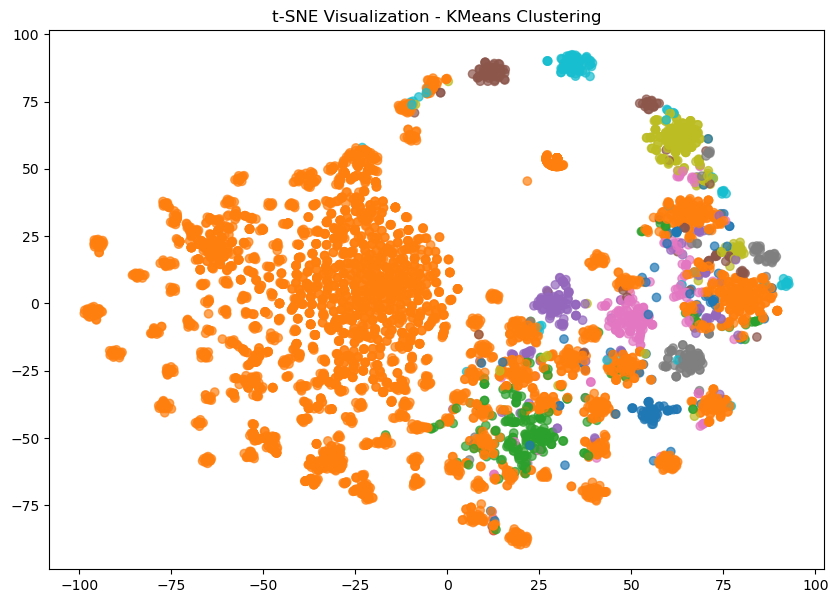

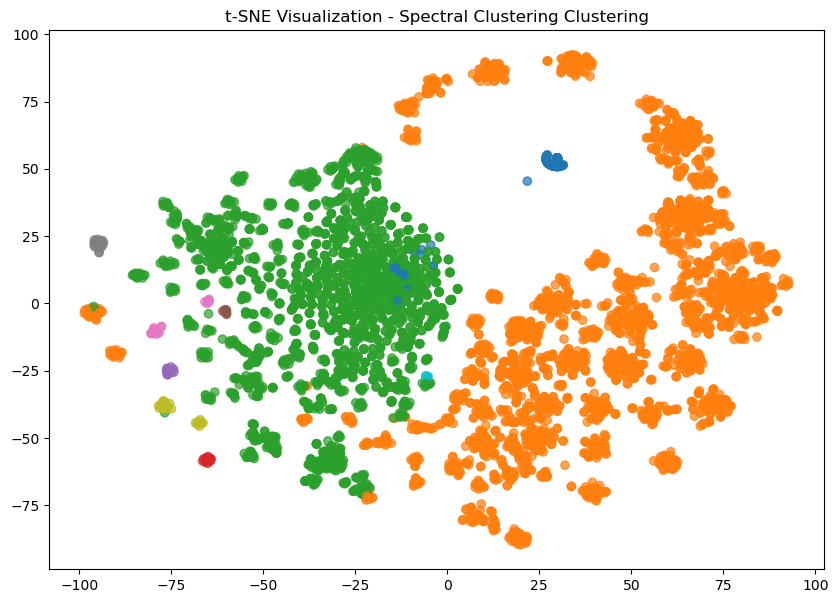

In [16]:
# Visualize clusters using t-SNE
from sklearn.manifold import TSNE

def visualize_clusters(data, labels, method):
    """
    Visualize clusters using t-SNE.
    """
    tsne = TSNE(n_components=2, random_state=42)
    tsne_data = tsne.fit_transform(data)

    plt.figure(figsize=(10, 7))
    plt.scatter(tsne_data[:, 0], tsne_data[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.title(f"t-SNE Visualization - {method} Clustering")
    plt.show()

# Visualize KMeans Clustering
visualize_clusters(reduced_matrix, kmeans_labels, "KMeans")

# Visualize Spectral Clustering
visualize_clusters(reduced_matrix, spectral_labels, "Spectral Clustering")


In [17]:
# Save cluster labels (if needed for later)

def save_cluster_labels(labels, method):
    """
    Save cluster labels as a dictionary.
    """
    cluster_dict = {f"U_{i}": label for i, label in enumerate(labels)}
    print(f"Cluster labels for {method}:")
    print(cluster_dict)

    return cluster_dict

# Save KMeans labels
kmeans_clusters = save_cluster_labels(kmeans_labels, "KMeans")

# Save Spectral Clustering labels
spectral_clusters = save_cluster_labels(spectral_labels, "Spectral Clustering")


Cluster labels for KMeans:
{'U_0': np.int32(2), 'U_1': np.int32(1), 'U_2': np.int32(1), 'U_3': np.int32(1), 'U_4': np.int32(1), 'U_5': np.int32(1), 'U_6': np.int32(1), 'U_7': np.int32(1), 'U_8': np.int32(9), 'U_9': np.int32(1), 'U_10': np.int32(1), 'U_11': np.int32(1), 'U_12': np.int32(1), 'U_13': np.int32(1), 'U_14': np.int32(1), 'U_15': np.int32(1), 'U_16': np.int32(1), 'U_17': np.int32(9), 'U_18': np.int32(5), 'U_19': np.int32(1), 'U_20': np.int32(1), 'U_21': np.int32(1), 'U_22': np.int32(8), 'U_23': np.int32(6), 'U_24': np.int32(1), 'U_25': np.int32(1), 'U_26': np.int32(6), 'U_27': np.int32(1), 'U_28': np.int32(1), 'U_29': np.int32(1), 'U_30': np.int32(1), 'U_31': np.int32(1), 'U_32': np.int32(1), 'U_33': np.int32(1), 'U_34': np.int32(9), 'U_35': np.int32(1), 'U_36': np.int32(3), 'U_37': np.int32(2), 'U_38': np.int32(1), 'U_39': np.int32(2), 'U_40': np.int32(1), 'U_41': np.int32(5), 'U_42': np.int32(0), 'U_43': np.int32(1), 'U_44': np.int32(0), 'U_45': np.int32(1), 'U_46': np.int32

## Part III

In [18]:
# Parameters for enhanced graph construction
INTRA_CLUSTER_WEIGHT = 1.0   # Weight for intra-cluster connections
INTER_CLUSTER_WEIGHT = 0.2   # Weight for inter-cluster connections
NUM_USERS = 1000
user_item_matrix = sub_matrix  # etc

# Choose the clustering method ('kmeans' or 'spectral')
CLUSTERING_METHOD = 'spectral'

# Select the labels based on the chosen clustering method
if CLUSTERING_METHOD == 'kmeans':
    cluster_labels = kmeans_labels
elif CLUSTERING_METHOD == 'spectral':
    cluster_labels = spectral_labels
else:
    raise ValueError("Invalid clustering method selected.")


In [19]:
import scipy.sparse as sp

def construct_enhanced_uu_graph(num_users, cluster_labels):
    """
    Construct the enhanced User-User graph based on cluster information.
    - Intra-cluster edges have higher weights.
    - Inter-cluster edges have lower weights.
    """
    # Initialize sparse adjacency matrix
    adj_matrix = sp.lil_matrix((num_users, num_users))

    # Iterate over all users to construct connections
    for i in range(num_users):
        for j in range(i + 1, num_users):
            if cluster_labels[i] == cluster_labels[j]:
                # Intra-cluster connection
                adj_matrix[i, j] = INTRA_CLUSTER_WEIGHT
                adj_matrix[j, i] = INTRA_CLUSTER_WEIGHT
            else:
                # Inter-cluster connection
                adj_matrix[i, j] = INTER_CLUSTER_WEIGHT
                adj_matrix[j, i] = INTER_CLUSTER_WEIGHT

    # Convert to CSR format for efficient processing
    adj_matrix = adj_matrix.tocsr()

    print(f"Enhanced User-User graph constructed with shape: {adj_matrix.shape}")
    return adj_matrix

# Construct the enhanced User-User graph
enhanced_uu_graph = construct_enhanced_uu_graph(NUM_USERS, cluster_labels)


Enhanced User-User graph constructed with shape: (1000, 1000)


In [20]:
def update_user_item_graph(train_matrix):
    """
    Update the User-Item graph by maintaining original connections.
    """
    # The User-Item matrix is directly derived from the original training matrix
    updated_ui_graph = train_matrix.tocsr()
    print(f"Updated User-Item graph shape: {updated_ui_graph.shape}")
    return updated_ui_graph

# Update User-Item graph
updated_ui_graph = update_user_item_graph(train_matrix)


Updated User-Item graph shape: (14680, 233261)


In [21]:
def create_feature_matrices(num_users, num_items, cluster_labels):
    # X_uu: Feature matrix for User-User graph (clusters as features)
    X_uu = np.zeros((num_users, NUM_CLUSTERS))
    for i in range(num_users):
        X_uu[i, cluster_labels[i]] = 1

    # X_ui: Feature matrix for User-Item graph (original matrix as features)
    X_ui = train_matrix.toarray()

    # Conversion en tenseur torch
    X_uu = torch.tensor(X_uu, dtype=torch.float32)  # reste sur CPU
    X_ui = torch.tensor(X_ui, dtype=torch.float32)  # reste sur CPU

    print(f"X_uu shape: {X_uu.shape}")
    print(f"X_ui shape: {X_ui.shape}")
    return X_ui, X_uu

## Part IV

In [22]:
import dgl, math, torch
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn
from dgl.nn.pytorch import GraphConv
import math
from torch.nn.init import xavier_normal_, constant_, xavier_uniform_




class UUGCNLayer(nn.Module):
    def __init__(self,
                 in_feats,
                 out_feats,
                 weight=False,
                 bias=False,
                 activation=None,
                 dropout=0.6):
        super(UUGCNLayer, self).__init__()
        self.bias = bias
        self._in_feats = in_feats
        self._out_feats = out_feats
        self.weight = weight
        self.dropout=nn.Dropout(p=dropout)
        if self.weight:
            self.u_w = nn.Parameter(torch.Tensor(in_feats, out_feats))
            xavier_uniform_(self.u_w)
        self._activation = activation

    # def forward(self, graph, feat):
    def forward(self, graph, u_f):
        with graph.local_scope():
            if self.weight:
                u_f = torch.mm(u_f, self.u_w)
            node_f = u_f
            # D^-1/2
            # degs = graph.out_degrees().to(feat.device).float().clamp(min=1)
            degs = graph.out_degrees().to(u_f.device).float().clamp(min=1)
            norm = torch.pow(degs, -0.5).view(-1, 1)
            # norm = norm.view(-1,1)
            # shp = norm.shape + (1,) * (feat.dim() - 1)
            # norm = t.reshape(norm, shp)

            node_f = node_f * norm

            graph.ndata['n_f'] = node_f
            # graph.edata['e_f'] = e_f
            graph.update_all(fn.copy_u(u='n_f', out='m'), reduce_func=fn.sum(msg='m', out='n_f'))

            rst = graph.ndata['n_f']

            degs = graph.in_degrees().to(u_f.device).float().clamp(min=1)
            norm = torch.pow(degs, -0.5).view(-1, 1)
            # shp = norm.shape + (1,) * (feat.dim() - 1)
            # norm = t.reshape(norm, shp)
            rst = rst * norm

            if self._activation is not None:
                rst = self._activation(rst)
            rst = self.dropout(rst)

            return rst
class GCNLayer(nn.Module):
    def __init__(self,
                 in_feats,
                 out_feats,
                 weight=False,
                 bias=False,
                 activation=None,
                 dropout=0.6):
        
        super(GCNLayer, self).__init__()
        self.bias = bias
        self._in_feats = in_feats
        self._out_feats = out_feats
        self.weight = weight
        self.dropout=nn.Dropout(p=dropout)
        if self.weight:
            self.u_w = nn.Parameter(torch.Tensor(in_feats, out_feats))
            self.v_w = nn.Parameter(torch.Tensor(in_feats, out_feats))
            # self.e_w = nn.Parameter(t.Tensor(in_feats, out_feats))
            xavier_uniform_(self.u_w)
            xavier_uniform_(self.v_w)
            # init.xavier_uniform_(self.e_w)
        self._activation = activation

    # def forward(self, graph, feat):
    def forward(self, graph, u_f, v_f):
        with graph.local_scope():
            if self.weight:
                u_f = torch.mm(u_f, self.u_w)
                v_f = torch.mm(v_f, self.v_w)
                # e_f = t.mm(e_f, self.e_w)
            node_f = torch.cat([u_f, v_f], dim=0)
            # D^-1/2
            # degs = graph.out_degrees().to(feat.device).float().clamp(min=1)
            degs = graph.out_degrees().to(u_f.device).float().clamp(min=1)
            norm = torch.pow(degs, -0.5).view(-1, 1)
            # norm = norm.view(-1,1)
            # shp = norm.shape + (1,) * (feat.dim() - 1)
            # norm = t.reshape(norm, shp)

            node_f = node_f * norm

            graph.ndata['n_f'] = node_f
            # graph.edata['e_f'] = e_f
            graph.update_all(fn.copy_u(u='n_f', out='m'), reduce_func=fn.sum(msg='m', out='n_f'))

            rst = graph.ndata['n_f']

            degs = graph.in_degrees().to(u_f.device).float().clamp(min=1)
            norm = torch.pow(degs, -0.5).view(-1, 1)
            # shp = norm.shape + (1,) * (feat.dim() - 1)
            # norm = t.reshape(norm, shp)
            rst = rst * norm

            if self._activation is not None:
                rst = self._activation(rst)
            rst=self.dropout(rst)

            return rst

class GCNModel(nn.Module):
    def __init__(self,args, n_user,n_item):
        super(GCNModel, self).__init__()
        self.n_user = n_user
        self.n_item = n_item
        self.n_hid = args.n_hid
        self.n_layers = args.n_layers
        self.s_layers = args.s_layers
        self.embedding_dict = self.init_weight(n_user, n_item, self.n_hid)
        self.act = nn.LeakyReLU(0.5, inplace=True)
        self.layers = nn.ModuleList()
        self.uu_Layers = nn.ModuleList()
        self.weight = args.weight
        self.dropout = args.dropout 
        for i in range(0, self.n_layers):
            self.layers.append(GCNLayer(self.n_hid, self.n_hid, weight=self.weight, bias=False, activation=self.act,dropout=self.dropout))
        for i in range(0, self.s_layers):
            self.uu_Layers.append(UUGCNLayer(self.n_hid,self.n_hid,weight=self.weight, bias=False, activation=self.act,dropout=self.dropout))
    def init_weight(self, userNum, itemNum, hide_dim):
        initializer = nn.init.xavier_uniform_

        embedding_dict = nn.ParameterDict({
            'user_emb': nn.Parameter(initializer(torch.empty(userNum, hide_dim))),
            'item_emb': nn.Parameter(initializer(torch.empty(itemNum, hide_dim))),
        })
        return embedding_dict
    def forward(self, uigraph, uugraph, isTrain=True):

        init_embedding = torch.concat([self.embedding_dict['user_emb'],self.embedding_dict['item_emb']],axis=0)
        init_user_embedding = self.embedding_dict['user_emb']
        all_embeddings = [init_embedding]
        all_uu_embeddings = [init_user_embedding]

        for i, layer in enumerate(self.layers):
            if i == 0:
                embeddings = layer(uigraph, self.embedding_dict['user_emb'], self.embedding_dict['item_emb'])
            else:
                embeddings = layer(uigraph, embeddings[:self.n_user], embeddings[self.n_user:])

            norm_embeddings = F.normalize(embeddings, p=2, dim=1)
            all_embeddings += [norm_embeddings]
        ui_embeddings = sum(all_embeddings)

        for i, layer in enumerate(self.uu_Layers):
            if i == 0:
                embeddings = layer(uugraph, self.embedding_dict['user_emb'])
            else:
                embeddings = layer(uugraph, embeddings)
            norm_embeddings = F.normalize(embeddings, p=2, dim=1)
            all_uu_embeddings +=[norm_embeddings]
        uu_embeddings = sum(all_uu_embeddings)

        return ui_embeddings,uu_embeddings




#Social hidden fully-connected architecture
class SDNet(nn.Module):
    """
    A deep neural network for the reverse diffusion preocess.
    """

    def __init__(self, in_dims, out_dims, emb_size, time_type="cat", norm=False, dropout=0.5):
        super(SDNet, self).__init__()
        self.in_dims = in_dims
        self.out_dims = out_dims
        assert out_dims[0] == in_dims[-1], "In and out dimensions must equal to each other."
        self.time_type = time_type
        self.time_emb_dim = emb_size
        self.norm = norm

        self.emb_layer = nn.Linear(self.time_emb_dim, self.time_emb_dim)

        if self.time_type == "cat":
            in_dims_temp = [self.in_dims[0] + self.time_emb_dim] + self.in_dims[1:]
        else:
            raise ValueError("Unimplemented timestep embedding type %s" % self.time_type)
        out_dims_temp = self.out_dims

        self.in_layers = nn.ModuleList([nn.Linear(d_in, d_out) \
                                        for d_in, d_out in zip(in_dims_temp[:-1], in_dims_temp[1:])])
        self.out_layers = nn.ModuleList([nn.Linear(d_in, d_out) \
                                         for d_in, d_out in zip(out_dims_temp[:-1], out_dims_temp[1:])])

        self.drop = nn.Dropout(dropout)
        self.init_weights()

    def init_weights(self):
        for layer in self.in_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0 / (fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for weights
            layer.bias.data.normal_(0.0, 0.001)

        for layer in self.out_layers:
            # Xavier Initialization for weights
            size = layer.weight.size()
            fan_out = size[0]
            fan_in = size[1]
            std = np.sqrt(2.0 / (fan_in + fan_out))
            layer.weight.data.normal_(0.0, std)

            # Normal Initialization for weights
            layer.bias.data.normal_(0.0, 0.001)

        size = self.emb_layer.weight.size()
        fan_out = size[0]
        fan_in = size[1]
        std = np.sqrt(2.0 / (fan_in + fan_out))
        self.emb_layer.weight.data.normal_(0.0, std)
        self.emb_layer.bias.data.normal_(0.0, 0.001)

    def forward(self, x, timesteps):
        time_emb = timestep_embedding(timesteps, self.time_emb_dim).to(x.device)
        emb = self.emb_layer(time_emb)
        if self.norm:
            x = F.normalize(x)
        x = self.drop(x)
        h = torch.cat([x, emb], dim=-1)
        for i, layer in enumerate(self.in_layers):
            h = layer(h)
            h = torch.tanh(h)

        for i, layer in enumerate(self.out_layers):
            h = layer(h)
            if i != len(self.out_layers) - 1:
                h = torch.tanh(h)

        return h


def timestep_embedding(timesteps, dim, max_period=10000):
    """
    Create sinusoidal timestep embeddings.

    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param dim: the dimension of the output.
    :param max_period: controls the minimum frequency of the embeddings.
    :return: an [N x dim] Tensor of positional embeddings.
    """

    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


def mean_flat(tensor):
    """
    Take the mean over all non-batch dimensions.
    """
    return tensor.mean(dim=list(range(1, len(tensor.shape))))



In [25]:

from DataHander import DataHandler

def dglgraph_to_adjacency_tensor(dgl_graph):
    num_nodes = dgl_graph.num_nodes()
    adj = torch.zeros((num_nodes, num_nodes), dtype=torch.float32, device=dgl_graph.device)
    src, dst = dgl_graph.edges()
    adj[src, dst] = 1.0
    adj[dst, src] = 1.0
    return adj

adj_uu = dglgraph_to_adjacency_tensor(handler.uu_graph)
print("adj_uu shape :", adj_uu.shape)
print("Nombre total de liens dans adj_uu :", int(adj_uu.sum().item() // 2))  # divisé par 2 si non orienté
print("Quelques voisins de l'utilisateur 0 :", torch.where(adj_uu[0] > 0)[0].tolist())

def compute_cosine_similarity_matrix(embeddings):
    norm_emb = F.normalize(embeddings, p=2, dim=1)
    return torch.matmul(norm_emb, norm_emb.T)

def supervised_contrastive_loss(embeddings, adj_matrix, temperature=0.1, alpha=10):
    B = embeddings.size(0)
    emb_norm = F.normalize(embeddings, p=2, dim=1)
    sim_matrix = torch.matmul(emb_norm, emb_norm.t())
    mask = torch.eye(B, dtype=torch.bool, device=embeddings.device)
    sim_matrix = sim_matrix.masked_fill(mask, -9e15)

    positives = sim_matrix[adj_matrix > 0]
    mask_diag = torch.eye(B, dtype=torch.bool, device=embeddings.device)
    valid_neg_mask = (adj_matrix == 0) & (~mask_diag)
    negatives = sim_matrix[valid_neg_mask]

    pos_loss = -positives.mean() if positives.numel() > 0 else 0.0
    neg_loss = negatives.mean() if negatives.numel() > 0 else 0.0
    loss = alpha * pos_loss + neg_loss

    # For logs
    stats = {
        "n_pos": positives.numel(),
        "n_neg": negatives.numel(),
        "pos_mean": positives.mean().item() if positives.numel() > 0 else float('nan'),
        "neg_mean": negatives.mean().item() if negatives.numel() > 0 else float('nan'),
        "loss": loss.item(),
    }
    return loss, stats

adj_uu shape : torch.Size([14680, 14680])
Nombre total de liens dans adj_uu : 251149
Quelques voisins de l'utilisateur 0 : [547, 2252, 2313, 2754, 4168, 4217, 5071, 7491, 7550, 9412, 9668, 11847, 13033, 13392, 14519, 14598]


In [27]:
import torch, pickle, time, os
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

from param import args
from DataHander import DataHandler
from models.model import SDNet ,GCNModel

from utils import load_model, save_model, fix_random_seed_as
from tqdm import tqdm

from models import diffusion_process as dp
from Utils.Utils import *
import logging
import sys





class Coach:


    def __init__(self, handler):
        self.args = args
        self.device = torch.device('cuda' if args.cuda and torch.cuda.is_available() else 'cpu')
        self.handler = handler
        self.train_loader = self.handler.trainloader
        self.valloader = self.handler.valloader
        self.testloader = self.handler.testloader
        self.n_user, self.n_item = self.handler.n_user, self.handler.n_item
        self.uiGraph = self.handler.ui_graph.to(self.device)
        self.uuGraph = self.handler.uu_graph.to(self.device)
        self.uu_graph_denoised = None  # Stocke le graphe UU débruité
        
        self.epoch_pos_means = []
        self.epoch_neg_means = []


        self.GCNModel = GCNModel(args, self.n_user, self.n_item).to(self.device)
        # Build diffusion process
        output_dims = [args.dims] + [args.n_hid]
        input_dims = output_dims[::-1]
        self.SDNet = SDNet(input_dims, output_dims, args.emb_size, time_type="cat", norm=args.norm).to(self.device)

        self.DiffProcess = dp.DiffusionProcess(args.noise_schedule, args.noise_scale, args.noise_min, args.noise_max, args.steps, self.device).to(self.device)

        self.optimizer1 = torch.optim.Adam([
            {'params': self.GCNModel.parameters(), 'weight_decay': 0},
        ], lr=args.lr)
        self.optimizer2 = torch.optim.Adam([
            {'params': self.SDNet.parameters(), 'weight_decay': 0},
        ], lr=args.difflr)
        self.scheduler1 = torch.optim.lr_scheduler.StepLR(
            self.optimizer1,
            step_size=args.decay_step,
            gamma=args.decay
        )
        self.scheduler2 = torch.optim.lr_scheduler.StepLR(
            self.optimizer2,
            step_size=args.decay_step,
            gamma=args.decay
        )

        self.train_loss = []
        self.his_recall = []
        self.his_ndcg  = []

    def train(self):
        args = self.args
        self.save_history = True
        log_format = '%(asctime)s %(message)s'
        logging.basicConfig(stream=sys.stdout, level=logging.INFO, format=log_format, datefmt='%m/%d %I:%M:%S %p')
        log_save = './History/' + args.dataset + '/'
        log_file = args.save_name
        fname = f'{log_file}.txt'
        fh = logging.FileHandler(os.path.join(log_save, fname))
        fh.setFormatter(logging.Formatter(log_format))
        logger = logging.getLogger()
        logger.addHandler(fh)
        logger.info(args)
        logger.info('================')
        best_recall, best_ndcg, best_epoch, wait = 0, 0, 0, 0
        start_time = time.time()

        for self.epoch in range(1, args.n_epoch + 1):
            epoch_losses = self.train_one_epoch()
            self.train_loss.append(epoch_losses)
            print('epoch {} done! elapsed {:.2f}.s, epoch_losses {}'.format(
                self.epoch, time.time() - start_time, epoch_losses
            ), flush=True)
        
        # Test and print Recall/NDCG every epoch
            recall, ndcg = self.test(self.testloader)
            print(f"[Epoch {self.epoch}] Recall@{args.topk}: {recall:.4f}, NDCG@{args.topk}: {ndcg:.4f}")
            similarity_score = self.evaluate_denoising()
            print(f"[Epoch {self.epoch}] Similarity Score = {similarity_score:.4f}")

        # Record history of recall and ndcg

            self.his_ndcg.append(ndcg)
            cur_best = recall + ndcg > best_recall + best_ndcg
            if cur_best:
                best_recall, best_ndcg, best_epoch = recall, ndcg, self.epoch
                wait = 0
            else:
                wait += 1
            logger.info('+ epoch {} tested, elapsed {:.2f}s, Recall@{}: {:.4f}, NDCG@{}: {:.4f}'.format(
                self.epoch, time.time() - start_time, args.topk, recall, args.topk, ndcg))
            if args.model_dir and cur_best:
                desc = args.save_name
                perf = ''
                fname = f'{args.desc}_{desc}_{perf}.pth'
                save_model(self.GCNModel, self.SDNet, os.path.join(args.model_dir, fname), self.optimizer1, self.optimizer2)

            if self.save_history:
                self.saveHistory()

            if wait >= args.patience:
                print(f'Early stop at epoch {self.epoch}, best epoch {best_epoch}')
                break

            print("\n=== Denoising Evaluation ===")
            similarity_score = self.evaluate_denoising()

        print(f'Best  Recall@{args.topk} {best_recall:.6f}, NDCG@{args.topk} {best_ndcg:.6f}', flush=True)

    # Log progression dans le terminal
        print(f"[Epoch {self.epoch}] Similarity Score = {similarity_score:.4f}")

        with torch.no_grad():
            z_u,_ = self.GCNModel(self.uiGraph, self.uuGraph)
            z_u, _ = self.GCNModel(self.uiGraph, self.uuGraph)

        # Si z_u contient [user_emb ; item_emb] → on prend uniquement les premiers n_user
            z_u = z_u[:self.n_user]

            t = torch.randint(0, self.args.steps, (self.n_user,), device=self.device)
            noise = torch.randn_like(z_u)
            x_t = self.DiffProcess.q_sample(z_u, t, noise)

            reconstructed_z_u = self.SDNet(x_t, t)

        # Matrice de similarité UU débruitée
            self.uu_graph_denoised = compute_cosine_similarity_matrix(reconstructed_z_u).cpu()



    def evaluate_denoising(self):
        """
        Evaluate denoising effectiveness using cosine similarity
        between original and reconstructed embeddings.
        """
        self.SDNet.eval()
        self.GCNModel.eval()

        with torch.no_grad():
            # Generate embeddings
            uiEmbeds, uuEmbeds = self.GCNModel(self.uiGraph, self.uuGraph, True)

            # Select a few users for evaluation
            num_samples = 64
            sample_users = torch.randint(0, self.n_user, (num_samples,)).long().to(self.device)
            original_embeddings = uuEmbeds[sample_users]

            # Reconstruct using SDNet
            reconstructed_embeddings = self.DiffProcess.p_sample(
                self.SDNet, original_embeddings, args.sampling_steps, args.sampling_noise
            )

            # Compute cosine similarity
            cos_sim = F.cosine_similarity(original_embeddings, reconstructed_embeddings, dim=1)
            similarity_score = cos_sim.mean().item()

            print(f"Similarity Score after Denoising: {similarity_score:.4f}")

        return similarity_score

    def train_one_epoch(self):
        self.SDNet.train()
        self.GCNModel.train()
        dataloader = self.train_loader
        epoch_losses = [0] * 3
        dataloader.dataset.negSampling()
        tqdm_dataloader = tqdm(dataloader)
        since = time.time()
        epoch_pos_means = []
        epoch_neg_means = []

    # Prepare adjacency matrix (trust)
        adj_uu = dglgraph_to_adjacency_tensor(self.uuGraph).to(self.device)

        for iteration, batch in enumerate(tqdm_dataloader):
            user_idx, pos_idx, neg_idx = batch

            user_idx = user_idx.long()
            pos_idx = pos_idx.long()
            neg_idx = neg_idx.long()

            user_idx = user_idx.to(self.device)
            pos_idx = pos_idx.to(self.device)
            neg_idx = neg_idx.to(self.device)

        # Forward pass GCNModel
            uiEmbeds, uuEmbeds = self.GCNModel(self.uiGraph, self.uuGraph, True)

            uEmbeds = uiEmbeds[:self.n_user]
            iEmbeds = uiEmbeds[self.n_user:]
            user = uEmbeds[user_idx]
            pos = iEmbeds[pos_idx]
            neg = iEmbeds[neg_idx]

            uu_terms = self.DiffProcess.caculate_losses(self.SDNet, uuEmbeds[user_idx], self.args.reweight)
            uuelbo = uu_terms["loss"].mean()
            user = user + uu_terms["pred_xstart"]
            diffloss = uuelbo
            scoreDiff = pairPredict(user, pos, neg)
            bprLoss = - (scoreDiff).sigmoid().log().sum() / self.args.batch_size
            regLoss = ((torch.norm(user) ** 2 + torch.norm(pos) ** 2 + torch.norm(neg) ** 2) * self.args.reg) / self.args.batch_size
            loss = bprLoss + regLoss
            losses = [bprLoss.item(), regLoss.item()]
            loss = diffloss + loss
            losses.append(diffloss.item())

        # CONTRASTIVE LOSS
            lambda_contrast = 10
            trust_mask = adj_uu[user_idx][:, user_idx]
            batch_embeddings = uuEmbeds[user_idx]
            loss_contrast, contrast_stats = supervised_contrastive_loss(
                batch_embeddings, trust_mask, temperature=0.1, alpha=10
            )
            loss = loss + lambda_contrast * loss_contrast
            epoch_pos_means.append(contrast_stats['pos_mean'])
            epoch_neg_means.append(contrast_stats['neg_mean'])
            
        # SPARSITY REGULARIZATION
            adj_pred = torch.matmul(F.normalize(uuEmbeds, p=2, dim=1), F.normalize(uuEmbeds, p=2, dim=1).T)
            sparsity_lambda = 0.01
            sparsity_loss = torch.abs(adj_pred).sum() / (adj_pred.shape[0] * adj_pred.shape[1])
            loss = loss + sparsity_lambda * sparsity_loss

        # === RECONSTRUCTION LOSS TRUST GRAPH ===
            beta_recon = 20.0  # Ajuste ce coefficient selon la dynamique de ta loss totale
            batch_uu_embeds = uuEmbeds[user_idx]
            batch_cos_sim = torch.matmul(
                F.normalize(batch_uu_embeds, p=2, dim=1),
                F.normalize(batch_uu_embeds, p=2, dim=1).T
            )
            batch_adj_trust = trust_mask  # Déjà la bonne taille (batch x batch)
            recon_loss = F.mse_loss(batch_cos_sim, batch_adj_trust)
            loss = loss + beta_recon * recon_loss

            if iteration == 0:
                n_pos = (trust_mask > 0).sum().item()
                n_neg = (trust_mask == 0).sum().item()
                print(f"[Epoch {self.epoch} | Batch {iteration}] Contrastive loss: {loss_contrast.item():.4f} | Positive pairs: {n_pos} | Negative pairs: {n_neg}")

            self.optimizer1.zero_grad()
            self.optimizer2.zero_grad()
            loss.backward()
            self.optimizer1.step()
            self.optimizer2.step()

            epoch_losses = [x + y for x, y in zip(epoch_losses, losses)]

        print(f"[EPOCH SUMMARY] adj_uu sum: {adj_uu.sum().item()}, size: {adj_uu.numel()}, densité: {adj_uu.sum().item() / adj_uu.numel():.6f}")
        if self.scheduler1 is not None:
            self.scheduler1.step()
            self.scheduler2.step()

        epoch_losses = [sum(epoch_losses)] + epoch_losses
        time_elapsed = time.time() - since
        print('Training complete in {:.4f}s'.format(time_elapsed))
        avg_pos = sum(epoch_pos_means) / len(epoch_pos_means)
        avg_neg = sum(epoch_neg_means) / len(epoch_neg_means)
        self.epoch_pos_means.append(avg_pos)
        self.epoch_neg_means.append(avg_neg)

        return epoch_losses





    def calcRes(self, topLocs, tstLocs, batIds):
        assert topLocs.shape[0] == len(batIds)
        allRecall = allNdcg = 0
        for i in range(len(batIds)):
            temTopLocs = list(topLocs[i])
            temTstLocs = tstLocs[batIds[i]]
            tstNum = len(temTstLocs)
            maxDcg = np.sum([np.reciprocal(np.log2(loc + 2)) for loc in range(min(tstNum, args.topk))])
            recall = dcg = 0
            for val in temTstLocs:
                if val in temTopLocs:
                    recall += 1
                    dcg += np.reciprocal(np.log2(temTopLocs.index(val) + 2))
            recall = recall / tstNum
            ndcg = dcg / maxDcg
            allRecall += recall
            allNdcg += ndcg
        return allRecall, allNdcg

    def test(self, dataloader):
        self.SDNet.eval()
        self.GCNModel.eval()
        Recall, NDCG = [0] * 2
        num = dataloader.dataset.__len__()

        since = time.time()
        with torch.no_grad():
            uiEmbeds, uuEmbeds = self.GCNModel(self.uiGraph, self.uuGraph, True)
            tqdm_dataloader = tqdm(dataloader)
            for iteration, batch in enumerate(tqdm_dataloader, start=1):
                user_idx, trnMask = batch
                user_idx = user_idx.long()
                trnMask = trnMask

                uEmbeds = uiEmbeds[:self.n_user]
                iEmbeds = uiEmbeds[self.n_user:]
                user = uEmbeds[user_idx]

                # Ensure trnMask is on the same device as user
                trnMask = trnMask.to(user.device)

                uuemb = uuEmbeds[user_idx]
                user_predict = self.DiffProcess.p_sample(self.SDNet, uuemb, args.sampling_steps, args.sampling_noise)
                user = user + user_predict
                allPreds = torch.mm(user, torch.transpose(iEmbeds, 1, 0)) * (1 - trnMask) - trnMask * 1e8
                _, topLocs = torch.topk(allPreds, args.topk)
                recall, ndcg = self.calcRes(topLocs.cpu().numpy(), dataloader.dataset.tstLocs, user_idx)
                Recall += recall
                NDCG += ndcg
            time_elapsed = time.time() - since
            print('Testing complete in {:.4f}s'.format(time_elapsed))
            Recall = Recall / num
            NDCG = NDCG / num
        return Recall, NDCG

    def saveHistory(self):
        history = dict()
        history['loss'] = self.train_loss
        history['Recall'] = self.his_recall
        history['NDCG'] = self.his_ndcg
        ModelName = "SDR"
        desc = args.save_name
        perf = ''
        fname = f'{args.desc}_{desc}_{perf}.his'

        with open('./History/' + args.dataset + '/' + fname, 'wb') as fs:
            pickle.dump(history, fs)

if __name__ == "__main__":
    os.environ['CUDA_VISIBLE_DEVICES'] = args.cuda
    fix_random_seed_as(args.seed)

    handler = DataHandler()
    handler.LoadData()
    app = Coach(handler)
    app.train()
    epochs = range(1, len(app.epoch_pos_means) + 1)


Nombre de nœuds dans uu_graph : 14680
Nombre d’arêtes dans uu_graph : 632144
Densité du graphe UU : 0.002934
06/05 02:02:25 PM Namespace(desc='', cuda='0', seed=2023, n_hid=32, n_layers=1, s_layers=2, weight=True, dropout=0.6, lr=0.003, difflr=0.0007, reg=0.05, decay=0.98, decay_step=2, n_epoch=2, batch_size=8192, patience=10, topk=50, test_batch_size=256, dataset='epinions', num_workers=0, save_name='tem', checkpoint='./Model/epinions/_tem_.pth', model_dir='./Model/epinions/', time_type='cat', dims=32, norm=True, emb_size=8, steps=20, noise_schedule='linear-var', noise_scale=1.5, noise_min=0.01, noise_max=0.2, sampling_noise=True, sampling_steps=10, reweight=True, user=np.int64(14680), item=np.int64(233261))
06/05 02:02:25 PM ================


  0%|          | 0/55 [00:00<?, ?it/s]

[Epoch 1 | Batch 0] Contrastive loss: -4.3393 | Positive pairs: 487700 | Negative pairs: 66621164


100%|██████████| 55/55 [04:53<00:00,  5.34s/it]

[EPOCH SUMMARY] adj_uu sum: 502298.0, size: 215502400, densité: 0.002331
Training complete in 293.6657s
epoch 1 done! elapsed 295.20.s, epoch_losses [57.44099801156712, 28.54803505539894, 12.428020924329758, 16.464942031838422]



100%|██████████| 56/56 [02:08<00:00,  2.30s/it]


Testing complete in 128.9965s
[Epoch 1] Recall@50: 0.0300, NDCG@50: 0.0158
Similarity Score after Denoising: 0.4330
[Epoch 1] Similarity Score = 0.4330
06/05 02:09:29 PM + epoch 1 tested, elapsed 424.24s, Recall@50: 0.0300, NDCG@50: 0.0158

=== Denoising Evaluation ===
Similarity Score after Denoising: 0.3757


  0%|          | 0/55 [00:00<?, ?it/s]

[Epoch 2 | Batch 0] Contrastive loss: -9.2175 | Positive pairs: 414074 | Negative pairs: 66694790


100%|██████████| 55/55 [04:52<00:00,  5.32s/it]

[EPOCH SUMMARY] adj_uu sum: 502298.0, size: 215502400, densité: 0.002331
Training complete in 292.7205s
epoch 2 done! elapsed 718.64.s, epoch_losses [42.966605587545956, 23.047675773501396, 10.924628488719463, 8.994301325325097]



100%|██████████| 56/56 [02:08<00:00,  2.30s/it]


Testing complete in 128.9022s
[Epoch 2] Recall@50: 0.0382, NDCG@50: 0.0215
Similarity Score after Denoising: 0.3359
[Epoch 2] Similarity Score = 0.3359
06/05 02:16:32 PM + epoch 2 tested, elapsed 847.62s, Recall@50: 0.0382, NDCG@50: 0.0215

=== Denoising Evaluation ===
Similarity Score after Denoising: 0.3759
Best  Recall@50 0.038244, NDCG@50 0.021547
[Epoch 2] Similarity Score = 0.3759


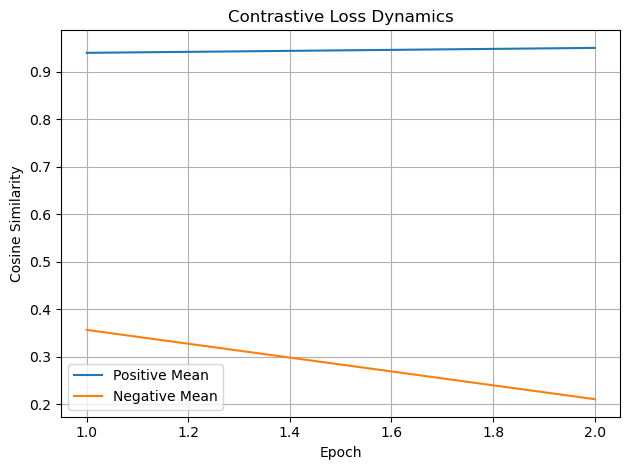

In [28]:
    plt.plot(epochs, app.epoch_pos_means, label='Positive Mean')
    plt.plot(epochs, app.epoch_neg_means, label='Negative Mean')
    plt.xlabel('Epoch')
    plt.ylabel('Cosine Similarity')
    plt.title('Contrastive Loss Dynamics')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

#test

## Tests / Verification


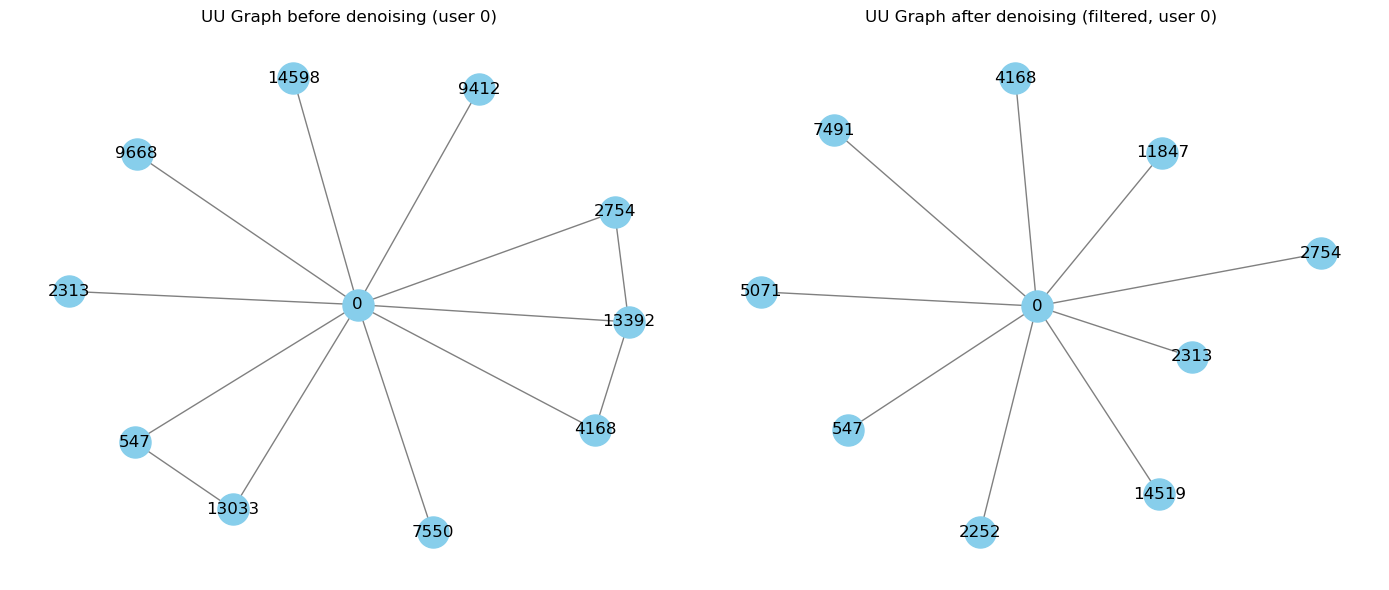

User 0:
  Original trusted users (16): [np.int32(547), np.int32(2252), np.int32(2313), np.int32(2754), np.int32(4168), np.int32(4217), np.int32(5071), np.int32(7491), np.int32(7550), np.int32(9412), np.int32(9668), np.int32(11847), np.int32(13033), np.int32(13392), np.int32(14519), np.int32(14598)]
  Users retained after denoising+filtering (9): [547, 2252, 2313, 2754, 4168, 5071, 7491, 11847, 14519]
  Trusted users retained (9): [547, 2252, 2313, 2754, 4168, 5071, 7491, 11847, 14519]
  Trusted users lost (7): [np.int32(4217), np.int32(7550), np.int32(9412), np.int32(9668), np.int32(13033), np.int32(13392), np.int32(14598)]
  New links (should be 0) (0): []
  Recall: 56.25%
  Precision: 100.00%



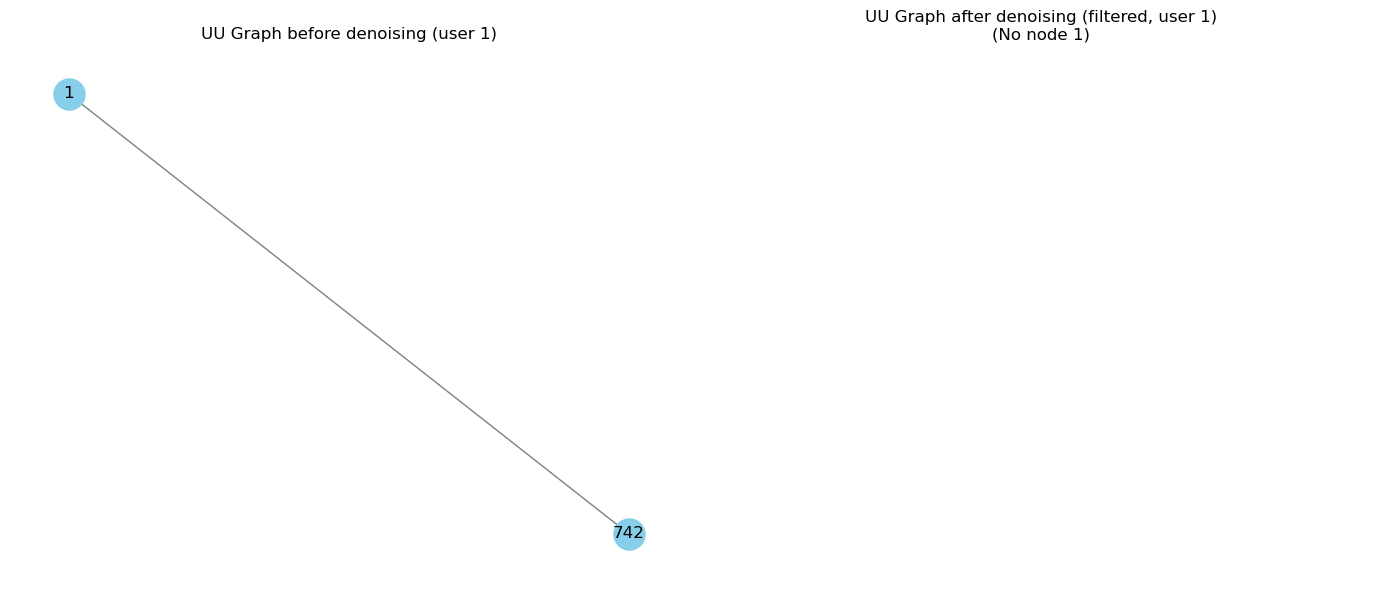

User 1:
  Original trusted users (1): [np.int32(742)]
  Users retained after denoising+filtering (0): []
  Trusted users retained (0): []
  Trusted users lost (1): [np.int32(742)]
  New links (should be 0) (0): []
  Recall: 0.00%
  Precision: 0.00%



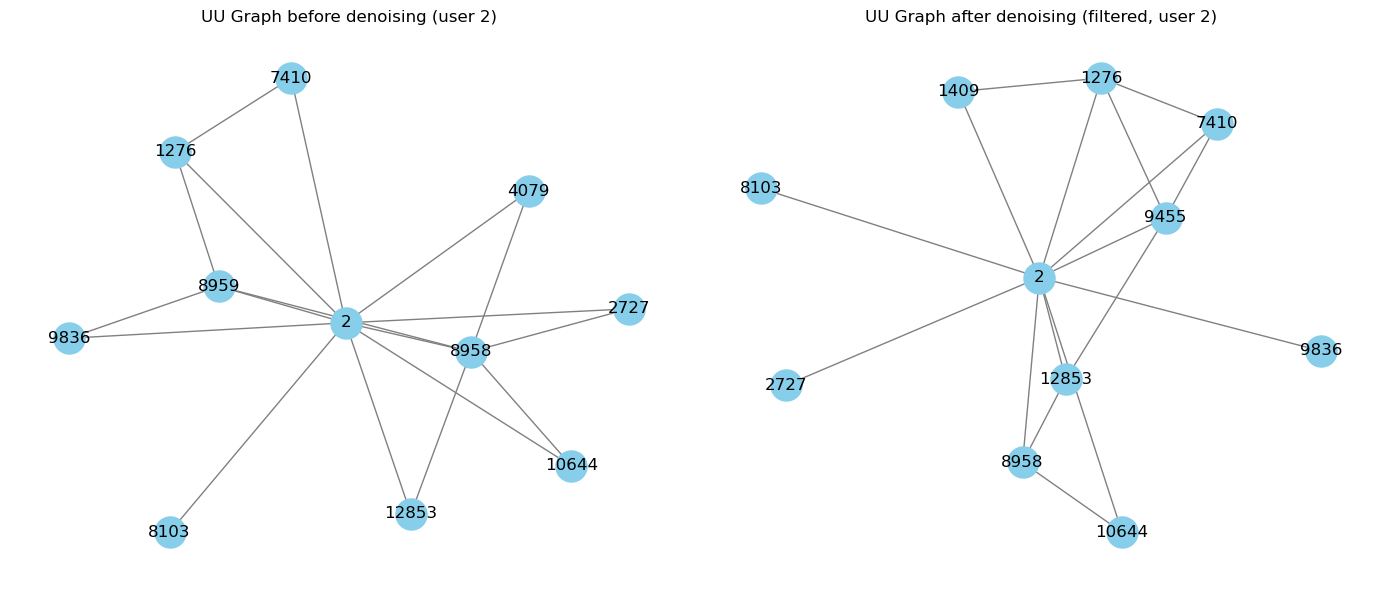

User 2:
  Original trusted users (12): [np.int32(1276), np.int32(1409), np.int32(2727), np.int32(4079), np.int32(7410), np.int32(8103), np.int32(8958), np.int32(8959), np.int32(9455), np.int32(9836), np.int32(10644), np.int32(12853)]
  Users retained after denoising+filtering (10): [1276, 1409, 2727, 7410, 8103, 8958, 9455, 9836, 10644, 12853]
  Trusted users retained (10): [1276, 1409, 2727, 7410, 8103, 8958, 9455, 9836, 10644, 12853]
  Trusted users lost (2): [np.int32(4079), np.int32(8959)]
  New links (should be 0) (0): []
  Recall: 83.33%
  Precision: 100.00%



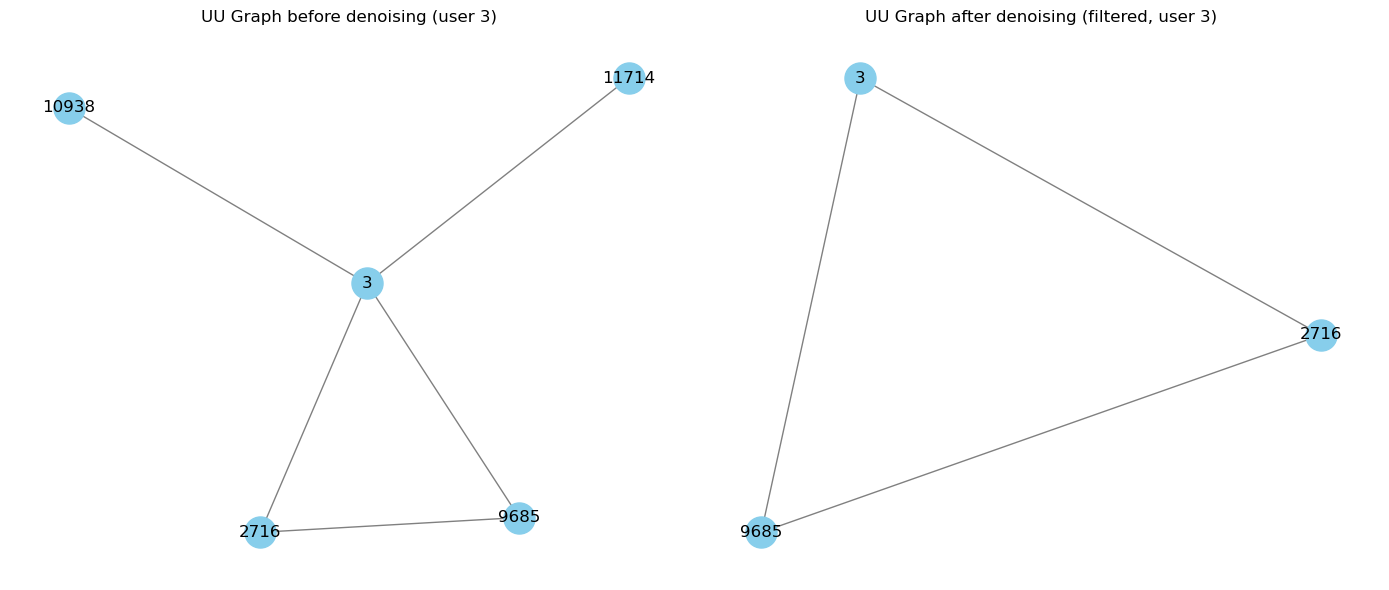

User 3:
  Original trusted users (4): [np.int32(2716), np.int32(9685), np.int32(10938), np.int32(11714)]
  Users retained after denoising+filtering (2): [2716, 9685]
  Trusted users retained (2): [2716, 9685]
  Trusted users lost (2): [np.int32(10938), np.int32(11714)]
  New links (should be 0) (0): []
  Recall: 50.00%
  Precision: 100.00%



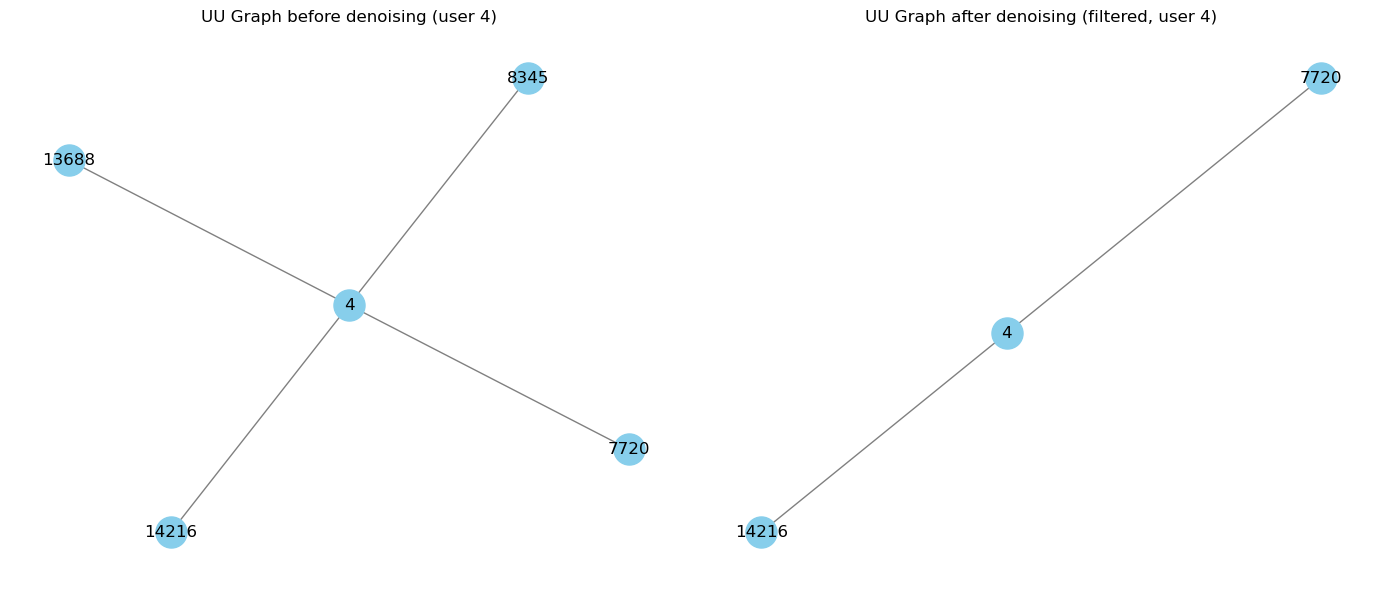

User 4:
  Original trusted users (4): [np.int32(7720), np.int32(8345), np.int32(13688), np.int32(14216)]
  Users retained after denoising+filtering (2): [7720, 14216]
  Trusted users retained (2): [7720, 14216]
  Trusted users lost (2): [np.int32(8345), np.int32(13688)]
  New links (should be 0) (0): []
  Recall: 50.00%
  Precision: 100.00%



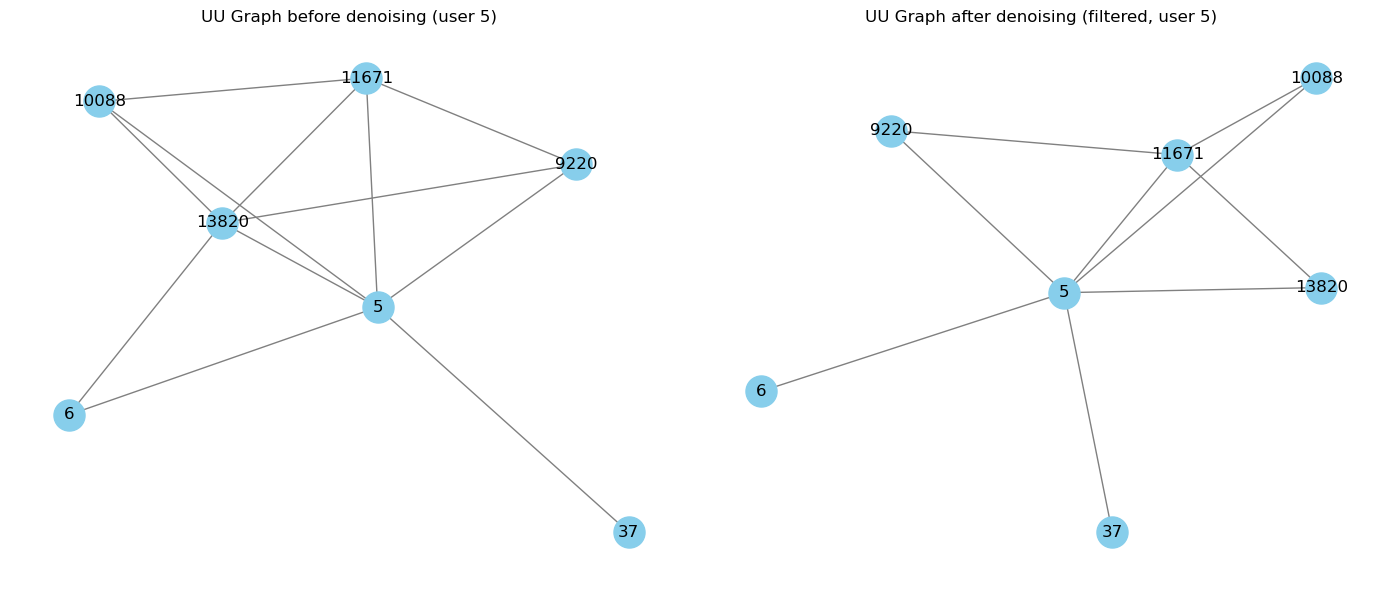

User 5:
  Original trusted users (6): [np.int32(6), np.int32(37), np.int32(9220), np.int32(10088), np.int32(11671), np.int32(13820)]
  Users retained after denoising+filtering (6): [6, 37, 9220, 10088, 11671, 13820]
  Trusted users retained (6): [6, 37, 9220, 10088, 11671, 13820]
  Trusted users lost (0): []
  New links (should be 0) (0): []
  Recall: 100.00%
  Precision: 100.00%



In [38]:
user_ids = [0, 1, 2, 3, 4, 5]

for user_id in user_ids:
    G_denoised_filtered = adjacency_tensor_to_nx_graph(adj_uu_denoised_filtered, threshold=0.5)
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    plot_limited_ego_graph(G_original, user_id, max_neighbors=10, ax=axes[0], title=f"UU Graph before denoising (user {user_id})")
    
    # Vérifier si le noeud existe dans le graphe filtré
    if user_id in G_denoised_filtered.nodes:
        plot_limited_ego_graph(G_denoised_filtered, user_id, max_neighbors=10, ax=axes[1], title=f"UU Graph after denoising (filtered, user {user_id})")
    else:
        axes[1].set_title(f"UU Graph after denoising (filtered, user {user_id})\n(No node {user_id})")
        axes[1].axis('off')
    plt.tight_layout()
    plt.show()

    # Diagnostic textuel
    trusted_users_original = set(trust_matrix.getrow(user_id).nonzero()[1])
    if user_id in G_denoised_filtered.nodes:
        retained_users_filtered = set(G_denoised_filtered.neighbors(user_id))
    else:
        retained_users_filtered = set()
    retained_trusted = trusted_users_original & retained_users_filtered
    lost_trusted = trusted_users_original - retained_users_filtered
    new_links = retained_users_filtered - trusted_users_original

    print(f"User {user_id}:")
    print(f"  Original trusted users ({len(trusted_users_original)}): {sorted(trusted_users_original)}")
    print(f"  Users retained after denoising+filtering ({len(retained_users_filtered)}): {sorted(retained_users_filtered)}")
    print(f"  Trusted users retained ({len(retained_trusted)}): {sorted(retained_trusted)}")
    print(f"  Trusted users lost ({len(lost_trusted)}): {sorted(lost_trusted)}")
    print(f"  New links (should be 0) ({len(new_links)}): {sorted(new_links)}")
    recall = len(retained_trusted) / len(trusted_users_original) if trusted_users_original else 0
    precision = len(retained_trusted) / len(retained_users_filtered) if retained_users_filtered else 0
    print(f"  Recall: {recall:.2%}")
    print(f"  Precision: {precision:.2%}\n")